In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as SklearnLR

# LinearRegression

Простая реализация линейной регрессии:  
$\hat{y} = \mathbf{w}^\top \mathbf{x} + b$

Поддерживает два метода обучения: аналитический и стохастический градиентный спуск (SGD) с L2-регуляризацией.

## Архитектура

| Атрибут      | Тип          | Описание                     |
|--------------|--------------|------------------------------|
| `weights`    | `np.ndarray` | Веса признаков, shape `(d,)` |
| `bias`       | `float`      | Смещение (свободный член)    |

Внутри методов веса и смещение временно объединяются в единый вектор  
$w = [b, w_1, w_2, \dots, w_d]^\top$ для удобства вычислений.

## Методы

### `.fit(X, y, method='analytic', ...)`
Обучает модель.

#### Параметры:
| Параметр     | Значение по умолчанию | Описание |
|--------------|-----------------------|----------|
| `method`     | `'analytic'`          | `'analytic'` — через обратную матрицу; `'sgd'` — градиентный спуск |
| `lr`         | `0.01`                | Скорость обучения (только для `sgd`) |
| `n_iter`     | `1000`                | Макс. число итераций (только для `sgd`) |
| `alpha`      | `0.0`                 | Коэффициент L2-регуляризации $\lambda$ (только для `sgd`, **bias не штрафуется**) |
| `init`       | `'zeros'`             | Инициализация весов для `sgd`: `'zeros'` или `'normal'` |

#### Особенности:
- **Аналитический метод**:  
  $w = (\tilde{X}^\top \tilde{X})^{-1} \tilde{X}^\top y$, где $\tilde{X} = [\mathbf{1}\ \vert\ X]$  
  Требует, чтобы $\tilde{X}^\top \tilde{X}$ была обратима. Иначе — `ValueError`.
- **SGD**:  
  Минимизирует  
 $$
\mathcal{L}(w) = \frac{1}{n} \sum_{i=1}^{n} \left( \tilde{x}_i^\top w - y_i \right)^2 \;+\; \alpha \sum_{j=1}^{d} w_j^2
$$

Обозначения:
- $n$ — количество объектов в обучающей выборке,
- $d$ — количество признаков (исходных, без bias),
- $\tilde{x}_i = [1,\, x_{i1},\, x_{i2},\, \dots,\, x_{id}]^\top$ — $i$-й объект, дополненный единицей для bias,
- $w = [w_0,\, w_1,\, \dots,\, w_d]^\top$ — вектор параметров, где $w_0 = b$ (bias),
- $y_i$ — истинное значение целевой переменной для $i$-го объекта,
- $\alpha \geq 0$ — коэффициент регуляризации.

Градиент:  
  $\nabla_w \mathcal{L} = \frac{2}{n} \tilde{X}^\top (\tilde{X} w - y) + 2\alpha \cdot [0, w_{1:}]^\top$  
  То есть bias ($w_0$) **не входит в регуляризационный штраф**.

Поддерживает **дообучение**: если `weights`/`bias` уже заданы — SGD продолжит с текущих значений.

### `.predict(X)`
Возвращает предсказания:  
$\hat{y} = X \cdot \texttt{weights} + \texttt{bias}$

Вызов до `.fit()` вызывает `RuntimeError`.

In [ ]:
class LinearRegression:
    def __init__(self):
        self.weights = None
        self.bias = None

    def _is_fitted(self):
        return self.weights is not None and self.bias is not None

    def fit(self, X, y, method='analytic', lr=0.01, n_iter=1000, alpha=0.0, tol=1e-6, init='zeros'):
        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y, dtype=np.float64).flatten()
        n_samples, n_features = X.shape

        X_tilde = np.column_stack([np.ones(n_samples), X])

        if method == 'analytic':
            XtX = X_tilde.T @ X_tilde
            Xty = X_tilde.T @ y
            try:
                w = np.linalg.inv(XtX) @ Xty
            except np.linalg.LinAlgError:
                raise ValueError("Матрица X̃ᵀX̃ вырождена. Попробуйте sgd или уменьшите размерность.")

        elif method == 'sgd':
            if self._is_fitted() and len(self.weights) == n_features:
                w = np.concatenate([[self.bias], self.weights])
            else:
                if init == 'zeros':
                    w = np.zeros(n_features + 1)
                elif init == 'normal':
                    w = np.random.randn(n_features + 1) * 0.01
                else:
                    raise ValueError("Начальная инициализация должна быть 'zeros' или 'normal'")

            for _ in range(n_iter):
                y_pred = X_tilde @ w
                errors = y_pred - y
                grad = (2.0 / n_samples) * (X_tilde.T @ errors)
                grad[1:] += 2 * alpha * w[1:]
                w -= lr * grad

                if np.linalg.norm(grad) < tol:
                    break

        else:
            raise ValueError("Метод должен быть 'analytic' или 'sgd'")

        self.bias = w[0]
        self.weights = w[1:]
        return self

    def predict(self, X):
        if not self._is_fitted():
            raise RuntimeError("Модель не обучена. Вызовите .fit() перед .predict().")

        X = np.asarray(X)
        return X @ self.weights + self.bias

In [ ]:
# Генерация данных: y = 2.5 * x + 1.0 + шум
np.random.seed(42)
n = 100
X = np.random.randn(n, 1) * 2
y = 2.5 * X.flatten() + 1.0 + np.random.randn(n) * 1.5

# Разделение
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Обучение — наша модель (analytic)
model_analytic = LinearRegression()
model_analytic.fit(X_train, y_train, method='analytic')

# Обучение — наша модель (sgd)
model_sgd = LinearRegression()
model_sgd.fit(X_train, y_train, method='sgd', lr=0.05, n_iter=2000, alpha=0.0, init='normal')

# Обучение — sklearn
sklearn_model = SklearnLR()
sklearn_model.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Предсказания на тесте
y_pred_analytic = model_analytic.predict(X_test)
y_pred_sgd = model_sgd.predict(X_test)
y_pred_sklearn = sklearn_model.predict(X_test)

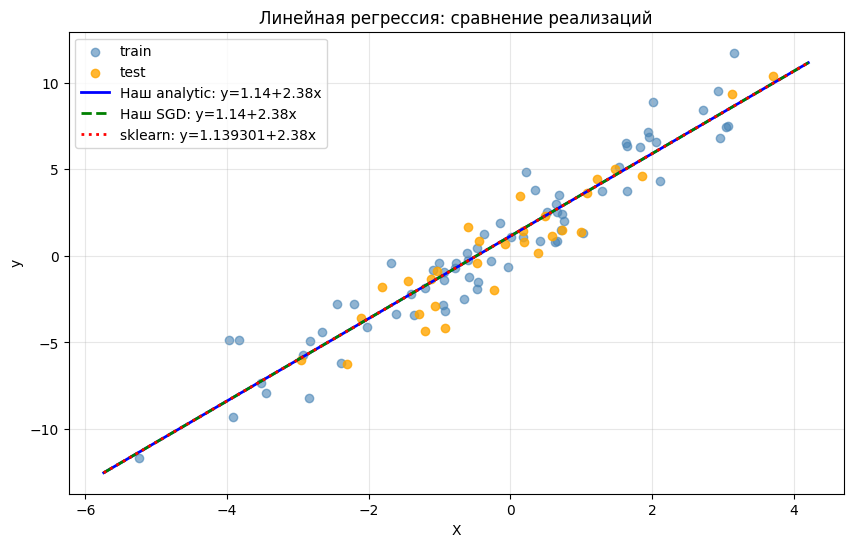

In [ ]:
# Визуализация
plt.figure(figsize=(10, 6))

# Точки
plt.scatter(X_train, y_train, c='steelblue', alpha=0.6, label='train')
plt.scatter(X_test, y_test, c='orange', alpha=0.8, label='test')

# Линии (строим по сетке для гладкости)
x_grid = np.linspace(X.min() - 0.5, X.max() + 0.5, 200).reshape(-1, 1)

y_line_analytic = model_analytic.predict(x_grid)
y_line_sgd = model_sgd.predict(x_grid)
y_line_sklearn = sklearn_model.predict(x_grid)

plt.plot(x_grid, y_line_analytic, 'b-', lw=2, label=f'Наш analytic: y={model_analytic.bias:.2f}+{model_analytic.weights[0]:.2f}x')
plt.plot(x_grid, y_line_sgd, 'g--', lw=2, label=f'Наш SGD: y={model_sgd.bias:.2f}+{model_sgd.weights[0]:.2f}x')
plt.plot(x_grid, y_line_sklearn, 'r:', lw=2, label=f'sklearn: y={sklearn_model.intercept_:2f}+{sklearn_model.coef_[0]:.2f}x')

plt.xlabel('X')
plt.ylabel('y')
plt.title('Линейная регрессия: сравнение реализаций')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Вывод весов и ошибок (MSE на тесте)
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

print("Веса и bias:")
print(f"Наш analytic:  bias = {model_analytic.bias:.6f}, weight = {model_analytic.weights[0]:.6f}")
print(f"Наш SGD:      bias = {model_sgd.bias:.6f}, weight = {model_sgd.weights[0]:.6f}")
print(f"sklearn:      bias = {sklearn_model.intercept_:.6f}, weight = {sklearn_model.coef_[0]:.6f}")

print("\nMSE на тестовой выборке:")
print(f"Наш analytic:  {mse(y_test, y_pred_analytic):.6f}")
print(f"Наш SGD:      {mse(y_test, y_pred_sgd):.6f}")
print(f"sklearn:      {mse(y_test, y_pred_sklearn):.6f}")

Веса и bias:
Наш analytic:  bias = 1.139301, weight = 2.380388
Наш SGD:      bias = 1.139301, weight = 2.380388
sklearn:      bias = 1.139301, weight = 2.380388

MSE на тестовой выборке:
Наш analytic:  1.921181
Наш SGD:      1.921180
sklearn:      1.921181
